# Preliminary Feature Selection and Exploratory Data Analysis

*Raiden Han*

In this notebook, I will use a random forest model to explore the permutation importance of the variables and incorporate Ward's linkage to select the variables to be entered into the model. Then, I will conduct an exploratory data analysis for each variable.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

## Preliminary Feature Selection

To prevent the introduction of unknown information, I will first partition the dataset into a training set and a test set on a scale of 80-20. Thereafter all explorations are performed on the training set.

In [2]:
data = pd.read_csv("data/primary_dataset.csv", index_col=0).dropna()
data.head()

,ORIG_UPB,OLTV,DTI,CSCORE_B,PURPOSE,PROP,NO_UNITS,OCC_STAT,LAST_UPB,LOSS_GIVEN_DEFAULT,DFF,UNRATE,CURR_HPI,MORTGAGE30US,MTM_LTV,INT_DIFF
0,68000.0,82,17.0,584.0,R,SF,1,P,66727.36,0.000000,1.79,6.7,260.090000,6.43,71.894627,1.570
1,81000.0,97,33.0,670.0,P,SF,1,P,81193.29,0.000000,6.17,3.6,236.990000,8.28,95.619083,-0.030
2,72000.0,78,3.0,718.0,C,SF,1,P,68384.97,0.000000,1.02,5.8,276.353333,6.28,62.297306,1.595
3,103000.0,97,36.0,640.0,P,MH,1,P,100694.32,0.049237,1.28,6.9,266.040000,5.26,82.833069,3.865
4,61000.0,75,45.0,630.0,C,PU,1,P,60261.78,0.756658,4.61,5.2,249.720000,7.14,69.726881,1.860


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(data.drop("LOSS_GIVEN_DEFAULT", axis=1), drop_first=True),
    data["LOSS_GIVEN_DEFAULT"],
    train_size=0.8, random_state=1104)
X_train.head()

,ORIG_UPB,OLTV,DTI,CSCORE_B,NO_UNITS,LAST_UPB,DFF,UNRATE,CURR_HPI,MORTGAGE30US,...,INT_DIFF,PURPOSE_P,PURPOSE_R,PURPOSE_U,PROP_CP,PROP_MH,PROP_PU,PROP_SF,OCC_STAT_P,OCC_STAT_S
4880,97000.0,90,52.0,668.0,1,83809.71,0.09,9.5,297.280000,3.62,...,3.130,1,0,0,0,1,0,0,1,0
190,45000.0,70,59.0,626.0,1,36693.57,1.97,5.8,286.510000,5.77,...,3.105,0,0,0,0,0,0,1,0,1
14350,126000.0,80,42.0,724.0,1,112654.50,0.30,5.1,334.353333,3.61,...,1.640,0,0,0,0,0,1,0,1,0
4066,137000.0,80,39.0,645.0,1,121683.22,0.17,10.4,314.340000,4.58,...,1.670,0,1,0,0,0,0,1,1,0
8593,65000.0,72,46.0,720.0,1,61648.24,0.23,10.8,335.506667,5.25,...,0.500,0,1,0,0,0,0,1,1,0


Then, I will build a random forest regressor and calculate the permutation importance.

In [4]:
clf = RandomForestRegressor(
    n_estimators=500, random_state=1104, criterion='absolute_error')
clf.fit(X_train, y_train)
result = permutation_importance(
    clf, X_train, y_train, n_repeats=10, random_state=1104)

The random forest importances from the training set and the permutation importances' mean and standard deviation are shown below.

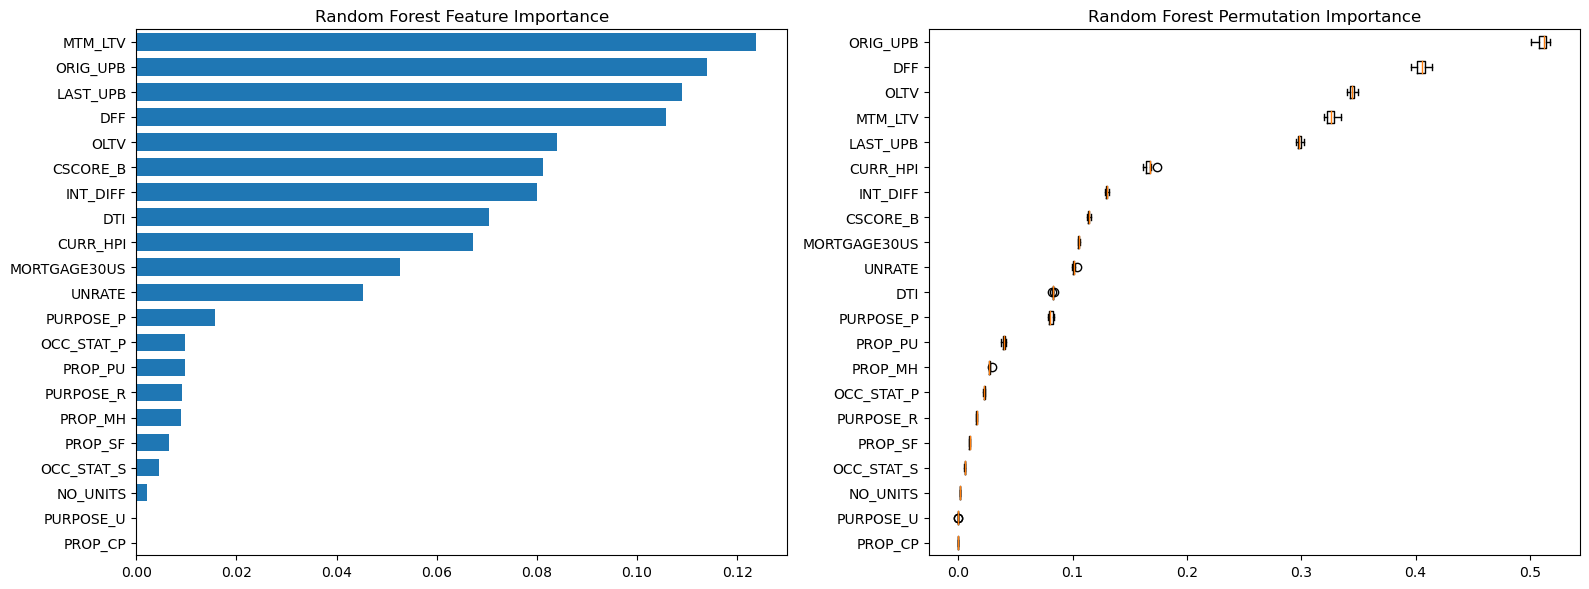

In [5]:
perm_sorted_idx = result.importances_mean.argsort()
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5
# Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].barh(tree_indices, clf.feature_importances_[
    tree_importance_sorted_idx], height=0.7)
ax[0].set_yticks(tree_indices)
ax[0].set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax[0].set_ylim((0, len(clf.feature_importances_)))
ax[1].boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
ax[0].set_title("Random Forest Feature Importance")
ax[1].set_title("Random Forest Permutation Importance")
fig.tight_layout()
plt.savefig("fig/feature_importance.png")
plt.show()

As shown above, Occupancy Status (OCC_STAT) and Number of Units (NO_UNITS) have low importance in the random forest regression model, implying that these two features are not effective in explaining LGD, so I will discard these two features.

Next, I will explore the correlations between the features. In particular, since I will use a nonlinear model in the next procedure, I will use Spearman's rank correlation coefficient
$$r_s=\rho_{R(X), R(Y)}=\frac{CoV(R(X),R(Y))}{\sigma_{R(X)}\sigma_{R(Y)}}.$$

In [6]:
corr = spearmanr(X_train).correlation
# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

/opt/anaconda3/envs/lgd_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/lgd_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


I will use the hierarchical clustering algorithm to show the distance between features. The original distance between features will be defined as $1-r_s$. Ward variance minimization algorithm will be used to measure the distance between clusters. From this algorithm, the new entry $d(u,v)$ is
$$d(u,v)=\sqrt{\frac{|v|+|s|}{T}d(v,s)^2+\frac{|v|+|t|}{T}d(v,t)^2-\frac{v}{T}d(s,t)^2},$$
where $u$ is the newly joined cluster consisting of clusters $s$ and $t$, $v$ is an unused cluster in the forest.

In [7]:
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

ValueError: Distance matrix 'X' must be symmetric.

The dendrogram is shown below.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
hierarchy.dendrogram(dist_linkage, labels=X_train.columns,
                     ax=ax, leaf_rotation=90)
ax.set_title("Features\' Hierarchical Clustering")
fig.tight_layout()
plt.savefig("fig/feature_dendrogram.png")
plt.show()

As can be seen in the above figure, the Original Unpaid Principal Balance (ORIG_UPB) and Last Unpaid Principal Balance (LAST_UPB) are very close to each other. The importance of both features is similar, but considering the stability of the data, I will choose Original Unpaid Principal Balance to be kept in the feature set. Similarly, Federal Funds Effective Rate (DFF) and 30-Year Fixed Rate Mortgage Average ( MORTGAGE30US) are also very close to each other. To facilitate the ease of interpretation of the final model, I will keep only the 30-Year Fixed Rate Mortgage Average.

## Exploratory Data Analysis

After discarding the four features selected above, I would like to observe the distribution of all numerical variables first.

In [ ]:
drop_list = ['OCC_STAT', 'NO_UNITS', 'LAST_UPB', 'DFF']
X_train = X_train.drop(drop_list, axis=1)
X_train.columns[X_train.dtypes != 'object']

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(24, 18))
ax[0, 0].hist(X_train['ORIG_UPB'], 20, density=True)
ax[0, 0].set_title("Original Unpaid Principal Balance")
ax[0, 1].hist(X_train['OLTV'], 9, range=(40, 100), density=True)
ax[0, 1].set_title("Original Loan to Value Ratio")
ax[0, 2].hist(X_train['DTI'], 20, density=True)
ax[0, 2].set_title("Debt-to-Income")
ax[1, 0].hist(X_train['CSCORE_B'], 20, range=(500, 810), density=True)
ax[1, 0].set_title("Borrower Credit Score at Origination")
ax[1, 1].hist(X_train['UNRATE'], 15, density=True)
ax[1, 1].set_title("Unemployment Rate")
ax[1, 2].hist(X_train['CURR_HPI'], 14, range=(250, 400), density=True)
ax[1, 2].set_title("Home Price Index")
ax[2, 0].hist(X_train['MORTGAGE30US'], 15, range=(3, 7.5), density=True)
ax[2, 0].set_title("30-Year Fixed Rate Mortgage Average")
ax[2, 1].hist(X_train['MTM_LTV'], 20, density=True)
ax[2, 1].set_title("Mark-to-Market Loan to Value Ratio")
ax[2, 2].hist(X_train['INT_DIFF'], 20, density=True)
ax[2, 2].set_title("Difference between Interest Rates")
fig.tight_layout()
fig.savefig("fig/feature_distribution.png")
plt.show()

From the above images, we can find that most of the features are symmetrically distributed, and only Original Unpaid Principal Balance and Original Loan to Value Ratio show obvious skewnesses. In order to increase the spread of the features while retaining the interpretability, I keep the other features and take the logarithm of the Original Unpaid Principal Balance to replace the original values.

Combining all of the above, I will perform feature removal and feature transformation on the original dataset and save it as a new dataset for subsequent modeling.

In [ ]:
data['LOG_OUPB'] = np.log(data['ORIG_UPB'])
data = data.drop(drop_list + ['ORIG_UPB'], axis=1)
data.to_csv("data/final_dataset.csv")